# Neural Storyteller – Image Captioning with Seq2Seq

**Course:** Generative AI (AI4009) – Spring 2026  
**University:** National University of Computer and Emerging Sciences  
**Assignment:** 01

---

## Objective
Build a multimodal deep learning model that generates natural language descriptions for images using a Sequence-to-Sequence (Seq2Seq) architecture with cached ResNet50 features and an LSTM decoder.

### IMPORTANT: Kaggle Setup
Before running this notebook on Kaggle:
1. **Turn ON Internet**: Right sidebar → Settings → Internet → ON (requires phone verification)
2. **Enable GPU**: Right sidebar → Settings → Accelerator → GPU T4 x2
3. **Add Dataset**: Right sidebar → + Add Data → Search "flickr30k" → Add it

## Step 0: Install Dependencies

In [1]:
# ---- Install Required Dependencies ----
!pip install nltk --quiet
print('All dependencies installed!')

All dependencies installed!


## Part 1: Feature Extraction Pipeline
Extract 2048-dim feature vectors from all images using a pre-trained ResNet50.

In [2]:
import os, pickle, torch, torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import numpy as np

# ---- Find the image directory ----
def find_image_dir():
    """Search /kaggle/input for a folder containing many .jpg files."""
    base_input = '/kaggle/input'
    if not os.path.exists(base_input):
        return None
    for root, dirs, files in os.walk(base_input):
        jpg_count = sum(1 for f in files if f.lower().endswith('.jpg'))
        if jpg_count > 1000:
            return root
    return None

IMAGE_DIR = find_image_dir()
OUTPUT_FILE = '/kaggle/working/flickr30k_features.pkl'

if IMAGE_DIR:
    print(f"Found images at: {IMAGE_DIR}")
    print(f"Number of JPGs: {sum(1 for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.jpg'))}")
else:
    # Show what's actually in /kaggle/input so user can debug
    print("Contents of /kaggle/input:")
    for item in os.listdir('/kaggle/input'):
        print(f"  {item}")
    raise FileNotFoundError(
        "Could not find images! Please add the Flickr30k dataset:\n"
        "  Right sidebar → + Add Data → Search 'flickr30k' → Add"
    )

Found images at: /kaggle/input/datasets/eeshawn/flickr30k/flickr30k_images
Number of JPGs: 31783


In [3]:
# ---- Feature Extraction with ResNet50 ----
class FlickrDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_names = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg'))])
        self.transform = transform
        self.img_dir = img_dir

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        name = self.img_names[idx]
        img = Image.open(os.path.join(self.img_dir, name)).convert('RGB')
        return self.transform(img), name

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ResNet50 and remove the final classification layer
resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # Output: (batch, 2048, 1, 1)
resnet = resnet.to(device)
resnet.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

dataset = FlickrDataset(IMAGE_DIR, transform)
loader = DataLoader(dataset, batch_size=128, num_workers=2, pin_memory=True)

features_dict = {}
with torch.no_grad():
    for imgs, names in tqdm(loader, desc='Extracting Features'):
        feats = resnet(imgs.to(device)).view(imgs.size(0), -1)  # (batch, 2048)
        for i, name in enumerate(names):
            features_dict[name] = feats[i].cpu().numpy()

with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(features_dict, f)

print(f"\nSuccess! {len(features_dict)} images → saved to {OUTPUT_FILE}")

# Free GPU memory from ResNet (we don't need it anymore)
del resnet
torch.cuda.empty_cache()

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 154MB/s]
Extracting Features: 100%|██████████| 249/249 [03:38<00:00,  1.14it/s]



Success! 31783 images → saved to /kaggle/working/flickr30k_features.pkl


## Part 2: Vocabulary & Text Pre-Processing
Load captions, clean text, build vocabulary, and prepare train/val/test splits.

In [4]:
import pandas as pd
import re
from collections import Counter
from sklearn.model_selection import train_test_split

# ---- Find captions file ----
def find_captions_file():
    base_input = '/kaggle/input'
    for root, dirs, files in os.walk(base_input):
        for f in files:
            if f.lower() in ['captions.txt', 'captions.csv', 'results.csv']:
                return os.path.join(root, f)
    return None

caption_file = find_captions_file()
if caption_file is None:
    raise FileNotFoundError('No captions file found in /kaggle/input!')
print(f"Caption file: {caption_file}")

# ---- Read captions (handle both pipe-separated and comma-separated) ----
# Try pipe separator first (results.csv format), then comma
try:
    df = pd.read_csv(caption_file, sep='|')
    if len(df.columns) < 2:
        raise ValueError('Not pipe-separated')
except:
    df = pd.read_csv(caption_file, sep=',')

df.columns = [c.strip() for c in df.columns]
print(f"Columns: {df.columns.tolist()}")
print(f"Total rows: {len(df)}")
df.head()

Caption file: /kaggle/input/datasets/eeshawn/flickr30k/captions.txt
Columns: ['image_name', 'comment_number', 'comment']
Total rows: 158915


,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [5]:
# ---- Clean Captions ----
print(f"Columns: {df.columns.tolist()}")

def clean_caption(text):
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_caption'] = df['comment'].apply(clean_caption)
df = df[df['image_name'].isin(features_dict.keys())].reset_index(drop=True)

print(f"Total rows: {len(df)}")
print(f"Unique images: {df['image_name'].nunique()}")
print(df[['comment', 'clean_caption']].head(10))

Columns: ['image_name', 'comment_number', 'comment']
Total rows: 158915
Unique images: 31783
                                             comment  \
0  Two young guys with shaggy hair look at their ...   
1  Two young  White males are outside near many b...   
2   Two men in green shirts are standing in a yard .   
3       A man in a blue shirt standing in a garden .   
4            Two friends enjoy time spent together .   
5  Several men in hard hats are operating a giant...   
6  Workers look down from up above on a piece of ...   
7   Two men working on a machine wearing hard hats .   
8              Four men on top of a tall structure .   
9                         Three men on a large rig .   

                                       clean_caption  
0  two young guys with shaggy hair look at their ...  
1  two young white males are outside near many bu...  
2     two men in green shirts are standing in a yard  
3         a man in a blue shirt standing in a garden  
4              

In [6]:
# ---- Build Vocabulary ----
MIN_WORD_FREQ = 5
PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN = '<pad>', '<start>', '<end>', '<unk>'

word_counts = Counter()
for cap in df['clean_caption']:
    word_counts.update(cap.split())

print(f"Unique words (raw): {len(word_counts)}")

vocab_words = sorted([w for w, c in word_counts.items() if c >= MIN_WORD_FREQ])
word2idx = {PAD_TOKEN: 0, START_TOKEN: 1, END_TOKEN: 2, UNK_TOKEN: 3}
for i, w in enumerate(vocab_words, start=4):
    word2idx[w] = i
idx2word = {v: k for k, v in word2idx.items()}
vocab_size = len(word2idx)

print(f"Vocabulary size (freq >= {MIN_WORD_FREQ}): {vocab_size}")

Unique words (raw): 19770
Vocabulary size (freq >= 5): 7689


In [7]:
# ---- Build Vocabulary ----
from collections import Counter
from sklearn.model_selection import train_test_split

# Define special tokens
PAD_TOKEN = '<PAD>'
START_TOKEN = '<START>'
END_TOKEN = '<END>'
UNK_TOKEN = '<UNK>'

# Count word frequencies
word_counts = Counter()
for caption in df['clean_caption']:
    word_counts.update(caption.split())

# Create vocabulary (filter rare words if needed)
MIN_WORD_FREQ = 5  # Adjust threshold as needed
vocab = [PAD_TOKEN, START_TOKEN, END_TOKEN, UNK_TOKEN]
vocab += [word for word, count in word_counts.items() if count >= MIN_WORD_FREQ]

# Create word-to-index and index-to-word mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

print(f"Vocabulary size: {len(vocab)}")
print(f"Total unique words (before filtering): {len(word_counts)}")

# ---- Encode Captions & Split Data ----
def encode_caption(caption, word2idx, max_len):
    tokens = [word2idx.get(w, word2idx[UNK_TOKEN]) for w in caption.split()]
    tokens = [word2idx[START_TOKEN]] + tokens + [word2idx[END_TOKEN]]
    if len(tokens) < max_len:
        tokens += [word2idx[PAD_TOKEN]] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len-1] + [word2idx[END_TOKEN]]
    return tokens

# Calculate max caption length
caption_lengths = df['clean_caption'].apply(lambda x: len(x.split()))
MAX_LEN = int(caption_lengths.quantile(0.95)) + 2
print(f"Max caption length (95th pctl + 2): {MAX_LEN}")

# Encode all captions
df['encoded'] = df['clean_caption'].apply(lambda x: encode_caption(x, word2idx, MAX_LEN))

# Split by unique images to avoid data leakage
unique_images = df['image_name'].unique()
train_imgs, temp_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

train_df = df[df['image_name'].isin(train_imgs)].reset_index(drop=True)
val_df   = df[df['image_name'].isin(val_imgs)].reset_index(drop=True)
test_df  = df[df['image_name'].isin(test_imgs)].reset_index(drop=True)

print(f"Train: {len(train_df)} captions ({len(train_imgs)} images)")
print(f"Val:   {len(val_df)} captions ({len(val_imgs)} images)")
print(f"Test:  {len(test_df)} captions ({len(test_imgs)} images)")

Vocabulary size: 7689
Total unique words (before filtering): 19770
Max caption length (95th pctl + 2): 24
Train: 127130 captions (25426 images)
Val:   15890 captions (3178 images)
Test:  15895 captions (3179 images)


In [8]:
# ---- PyTorch Datasets & DataLoaders ----
class CaptionDataset(Dataset):
    def __init__(self, dataframe, features_dict):
        self.data = dataframe
        self.features = features_dict

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_feat = torch.tensor(self.features[row['image_name']], dtype=torch.float32)
        caption = torch.tensor(row['encoded'], dtype=torch.long)
        return img_feat, caption

BATCH_SIZE = 128
train_loader = DataLoader(CaptionDataset(train_df, features_dict), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(CaptionDataset(val_df, features_dict),   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(CaptionDataset(test_df, features_dict),  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Batches → Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Batches → Train: 994, Val: 125, Test: 125


## Part 3: Seq2Seq Architecture
- **Encoder**: Projects 2048-dim ResNet features → 512-dim hidden state
- **Decoder**: LSTM that generates captions word-by-word with teacher forcing

In [9]:
import torch
import torch.nn as nn

# ---- Define device ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---- Define vocab_size ----
vocab_size = len(vocab)  # vocab was created in the previous vocabulary building step
print(f"Vocabulary size: {vocab_size}")

# ---- Model Definition ----
class ImageEncoder(nn.Module):
    def __init__(self, feature_dim=2048, hidden_size=512):
        super().__init__()
        self.fc = nn.Linear(feature_dim, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)  # Changed from BatchNorm1d
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        return self.dropout(self.relu(self.ln(self.fc(x))))

class CaptionDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, captions, hidden):
        embeds = self.dropout(self.embedding(captions))
        lstm_out, hidden = self.lstm(embeds, hidden)
        return self.fc_out(lstm_out), hidden

class Seq2SeqCaptioner(nn.Module):
    def __init__(self, vocab_size, feature_dim=2048, embed_size=256, hidden_size=512, num_layers=2, dropout=0.3):
        super().__init__()
        self.encoder = ImageEncoder(feature_dim, hidden_size)
        self.decoder = CaptionDecoder(vocab_size, embed_size, hidden_size, num_layers, dropout)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, img_features, captions):
        enc_out = self.encoder(img_features)
        h0 = enc_out.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)
        outputs, _ = self.decoder(captions[:, :-1], (h0, c0))
        return outputs

# ---- Create model ----
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 2
DROPOUT = 0.3

model = Seq2SeqCaptioner(
    vocab_size=vocab_size, 
    feature_dim=2048,
    embed_size=EMBED_SIZE, 
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS, 
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model created on {device}")
print(model)
print(f"\nTotal params: {total_params:,} | Trainable: {trainable_params:,}")

Using device: cuda
Vocabulary size: 7689
Model created on cuda
Seq2SeqCaptioner(
  (encoder): ImageEncoder(
    (fc): Linear(in_features=2048, out_features=512, bias=True)
    (ln): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (relu): ReLU()
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): CaptionDecoder(
    (embedding): Embedding(7689, 256, padding_idx=0)
    (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
    (fc_out): Linear(in_features=512, out_features=7689, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)

Total params: 10,641,161 | Trainable: 10,641,161


## Part 4: Training & Inference

In [10]:
# ---- Training Setup ----
LEARNING_RATE = 3e-4
NUM_EPOCHS = 25
CLIP_GRAD = 5.0

criterion = nn.CrossEntropyLoss(ignore_index=word2idx[PAD_TOKEN])
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, n = 0.0, 0
    for img_feats, captions in tqdm(loader, desc='Training', leave=False):
        img_feats, captions = img_feats.to(device), captions.to(device)
        outputs = model(img_feats, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
        optimizer.step()
        total_loss += loss.item()
        n += 1
    return total_loss / n

def validate(model, loader, criterion, device):
    model.eval()
    total_loss, n = 0.0, 0
    with torch.no_grad():
        for img_feats, captions in tqdm(loader, desc='Validating', leave=False):
            img_feats, captions = img_feats.to(device), captions.to(device)
            outputs = model(img_feats, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            total_loss += loss.item()
            n += 1
    return total_loss / n

print('Training functions ready.')

Training functions ready.


In [11]:
# ---- Training Loop ----
train_losses = []
val_losses = []
best_val_loss = float('inf')

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f'Epoch [{epoch:02d}/{NUM_EPOCHS}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}', end='')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, '/kaggle/working/best_captioner.pth')
        print(f' ✓ Saved best')
    else:
        print()

print('\nTraining complete!')

Epoch [01/25] | Train Loss: 4.4738 | Val Loss: 3.8315 ✓ Saved best


Epoch [02/25] | Train Loss: 3.6411 | Val Loss: 3.4392 ✓ Saved best


Epoch [03/25] | Train Loss: 3.3331 | Val Loss: 3.2508 ✓ Saved best


Epoch [04/25] | Train Loss: 3.1497 | Val Loss: 3.1429 ✓ Saved best


Epoch [05/25] | Train Loss: 3.0205 | Val Loss: 3.0706 ✓ Saved best


Epoch [06/25] | Train Loss: 2.9223 | Val Loss: 3.0258 ✓ Saved best


Epoch [07/25] | Train Loss: 2.8419 | Val Loss: 2.9940 ✓ Saved best


Epoch [08/25] | Train Loss: 2.7733 | Val Loss: 2.9692 ✓ Saved best


Epoch [09/25] | Train Loss: 2.7147 | Val Loss: 2.9496 ✓ Saved best


Epoch [10/25] | Train Loss: 2.6629 | Val Loss: 2.9406 ✓ Saved best


Epoch [11/25] | Train Loss: 2.6164 | Val Loss: 2.9257 ✓ Saved best


Epoch [12/25] | Train Loss: 2.5734 | Val Loss: 2.9230 ✓ Saved best


Epoch [13/25] | Train Loss: 2.5341 | Val Loss: 2.9180 ✓ Saved best


Epoch [14/25] | Train Loss: 2.4973 | Val Loss: 2.9138 ✓ Saved best


Epoch [15/25] | Train Loss: 2.4643 | Val Loss: 2.9138


Epoch [16/25] | Train Loss: 2.4327 | Val Loss: 2.9146


Epoch [17/25] | Train Loss: 2.4032 | Val Loss: 2.9131 ✓ Saved best


Epoch [18/25] | Train Loss: 2.3752 | Val Loss: 2.9168


Epoch [19/25] | Train Loss: 2.3482 | Val Loss: 2.9200


Epoch [20/25] | Train Loss: 2.3231 | Val Loss: 2.9230


Epoch [21/25] | Train Loss: 2.2992 | Val Loss: 2.9254


Epoch [22/25] | Train Loss: 2.2455 | Val Loss: 2.9231


Epoch [23/25] | Train Loss: 2.2269 | Val Loss: 2.9269


Epoch [24/25] | Train Loss: 2.2136 | Val Loss: 2.9296


Epoch [25/25] | Train Loss: 2.1999 | Val Loss: 2.9347

Training complete!


In [12]:
# ---- Inference: Greedy Search & Beam Search ----

def greedy_search(model, img_feature, word2idx, idx2word, max_len=30, device='cuda'):
    model.eval()
    with torch.no_grad():
        img_feat = torch.tensor(img_feature, dtype=torch.float32).unsqueeze(0).to(device)
        enc_out = model.encoder(img_feat)
        h = enc_out.unsqueeze(0).repeat(model.num_layers, 1, 1)
        c = torch.zeros_like(h)
        token = torch.tensor([[word2idx['<START>']]], dtype=torch.long).to(device)
        words = []
        for _ in range(max_len):
            out, (h, c) = model.decoder(token, (h, c))
            idx = out.argmax(dim=-1).item()
            if idx == word2idx['<END>']:
                break
            words.append(idx2word.get(idx, '<UNK>'))
            token = torch.tensor([[idx]], dtype=torch.long).to(device)
    return ' '.join(words)


def beam_search(model, img_feature, word2idx, idx2word, beam_width=5, max_len=30, device='cuda'):
    model.eval()
    with torch.no_grad():
        img_feat = torch.tensor(img_feature, dtype=torch.float32).unsqueeze(0).to(device)
        enc_out = model.encoder(img_feat)
        h0 = enc_out.unsqueeze(0).repeat(model.num_layers, 1, 1)
        c0 = torch.zeros_like(h0)

        beams = [(0.0, [word2idx['<START>']], (h0, c0))]
        completed = []

        for _ in range(max_len):
            candidates = []
            for log_p, seq, (h, c) in beams:
                token = torch.tensor([[seq[-1]]], dtype=torch.long).to(device)
                out, (h_new, c_new) = model.decoder(token, (h, c))
                log_probs = torch.log_softmax(out.squeeze(0).squeeze(0), dim=-1)
                top_lp, top_idx = log_probs.topk(beam_width)
                for i in range(beam_width):
                    tid = top_idx[i].item()
                    new_lp = log_p + top_lp[i].item()
                    new_seq = seq + [tid]
                    if tid == word2idx['<END>']:
                        completed.append((new_lp / len(new_seq), new_seq))
                    else:
                        candidates.append((new_lp, new_seq, (h_new, c_new)))
            if not candidates:
                break
            candidates.sort(key=lambda x: x[0], reverse=True)
            beams = candidates[:beam_width]

        if not completed:
            best_seq = beams[0][1]
        else:
            completed.sort(key=lambda x: x[0], reverse=True)
            best_seq = completed[0][1]

        words = [idx2word.get(i, '<UNK>') for i in best_seq
                 if i != word2idx['<START>'] and i != word2idx['<END>']]
    return ' '.join(words)


print('Inference functions defined: greedy_search() and beam_search()')

Inference functions defined: greedy_search() and beam_search()


## Deliverables
### 1. Caption Examples

Loaded best model from epoch 17 (val_loss: 2.9131)


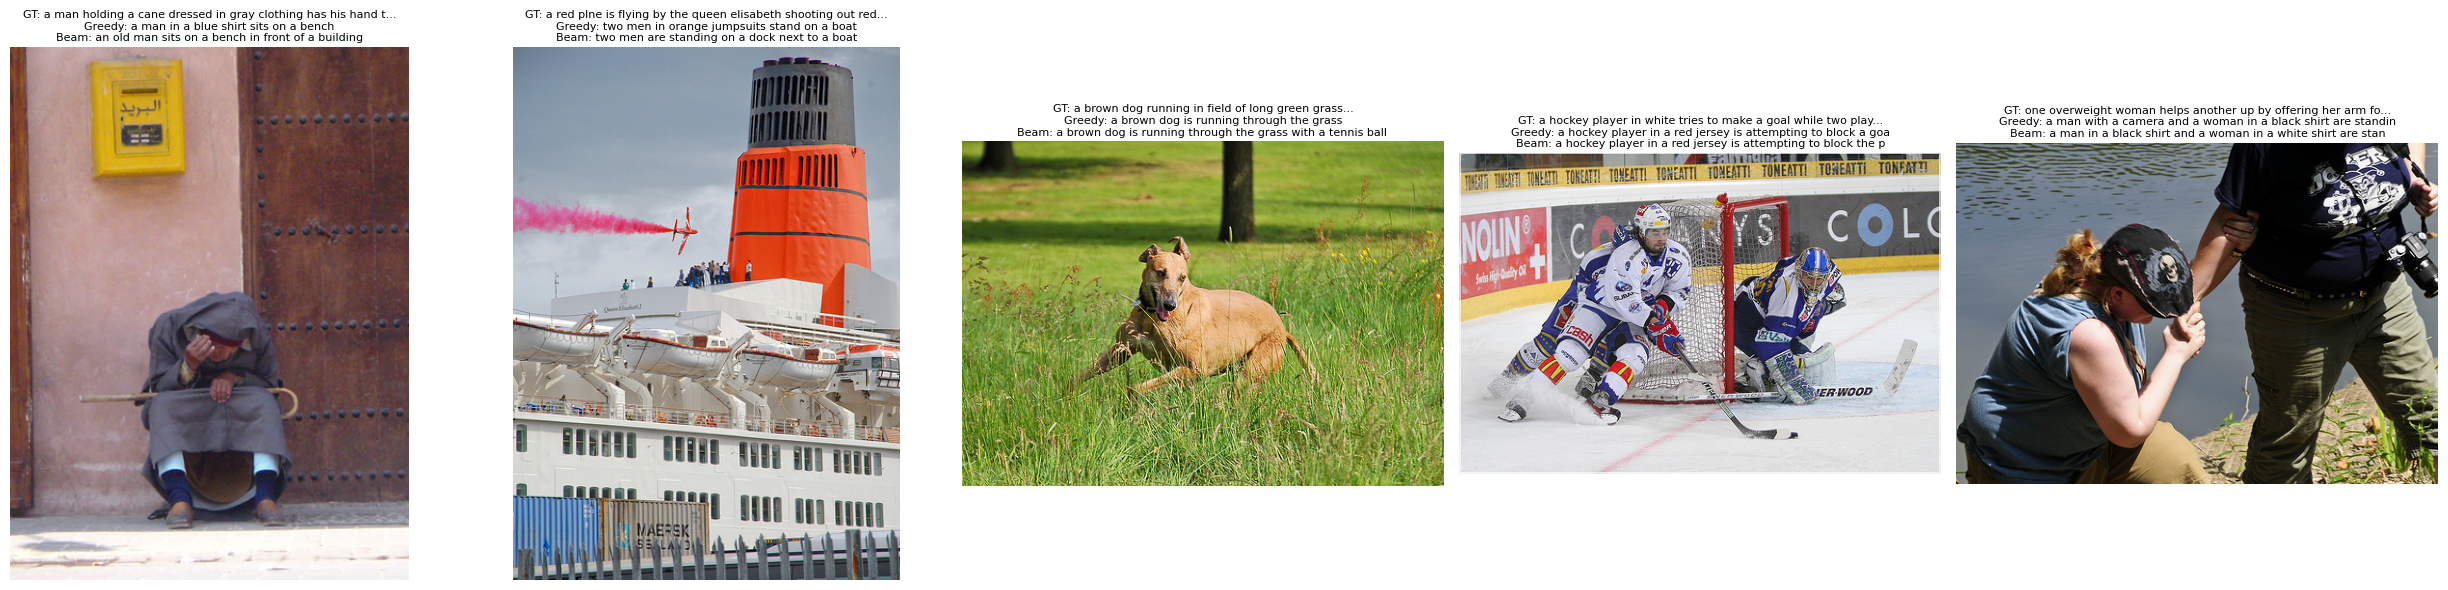

Caption examples saved.


In [13]:
import matplotlib.pyplot as plt
import random

# Load best model
checkpoint = torch.load('/kaggle/working/best_captioner.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.4f})")

# Pick 5 random test images
test_images = test_df['image_name'].unique()
sample_images = random.sample(list(test_images), min(5, len(test_images)))

fig, axes = plt.subplots(1, 5, figsize=(25, 6))
for ax, img_name in zip(axes, sample_images):
    img = Image.open(os.path.join(IMAGE_DIR, img_name)).convert('RGB')
    ax.imshow(img)
    ax.axis('off')

    gt = test_df[test_df['image_name'] == img_name]['clean_caption'].iloc[0]
    feat = features_dict[img_name]
    greedy_cap = greedy_search(model, feat, word2idx, idx2word, device=device)
    beam_cap = beam_search(model, feat, word2idx, idx2word, beam_width=5, device=device)

    ax.set_title(f"GT: {gt[:60]}...\nGreedy: {greedy_cap[:60]}\nBeam: {beam_cap[:60]}", fontsize=8, wrap=True)

plt.tight_layout()
plt.savefig('/kaggle/working/caption_examples.png', dpi=150, bbox_inches='tight')
plt.show()
print('Caption examples saved.')

### 2. Loss Curve

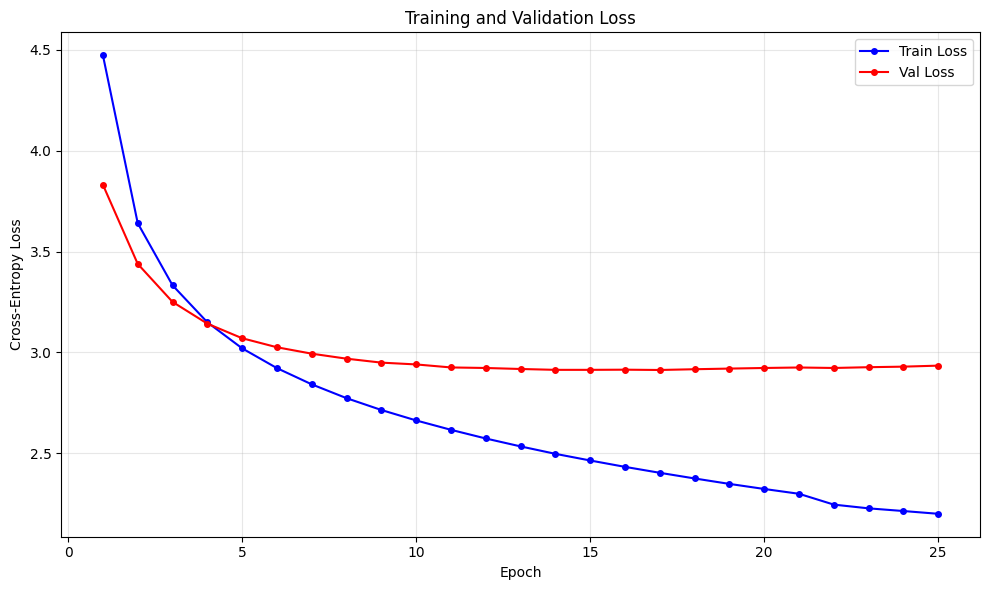

Loss curve saved.


In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-o', label='Train Loss', markersize=4)
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-o', label='Val Loss', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/kaggle/working/loss_curve.png', dpi=150)
plt.show()
print('Loss curve saved.')

### 3. Quantitative Evaluation
BLEU-4, Precision, Recall, F1, METEOR

In [15]:
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

def token_metrics(ref_tokens, pred_tokens):
    ref_c = Counter(ref_tokens)
    pred_c = Counter(pred_tokens)
    tp = sum((ref_c & pred_c).values())
    prec = tp / max(len(pred_tokens), 1)
    rec = tp / max(len(ref_tokens), 1)
    f1 = (2 * prec * rec) / max(prec + rec, 1e-8)
    return prec, rec, f1

# Group test captions by image
test_grouped = test_df.groupby('image_name')['clean_caption'].apply(list).to_dict()

all_refs, all_hyps = [], []
all_prec, all_rec, all_f1, all_meteor = [], [], [], []

print('Evaluating on test set...')
for img_name in tqdm(test_grouped.keys(), desc='Generating captions'):
    feat = features_dict[img_name]
    pred_cap = beam_search(model, feat, word2idx, idx2word, beam_width=5, device=device)
    pred_tokens = pred_cap.split()

    ref_captions = test_grouped[img_name]
    ref_token_lists = [c.split() for c in ref_captions]

    all_refs.append(ref_token_lists)
    all_hyps.append(pred_tokens)

    # Token-level metrics (avg across references)
    ps, rs, fs = [], [], []
    for rt in ref_token_lists:
        p, r, f = token_metrics(rt, pred_tokens)
        ps.append(p); rs.append(r); fs.append(f)
    all_prec.append(np.mean(ps))
    all_rec.append(np.mean(rs))
    all_f1.append(np.mean(fs))

    # METEOR (best across references)
    m_scores = [meteor_score([rt], pred_tokens) for rt in ref_token_lists]
    all_meteor.append(max(m_scores))

# Corpus BLEU-4
smooth = SmoothingFunction().method1
bleu4 = corpus_bleu(all_refs, all_hyps, smoothing_function=smooth)

print('\n' + '='*50)
print('QUANTITATIVE EVALUATION RESULTS')
print('='*50)
print(f'BLEU-4 Score:     {bleu4:.4f}')
print(f'Avg Precision:    {np.mean(all_prec):.4f}')
print(f'Avg Recall:       {np.mean(all_rec):.4f}')
print(f'Avg F1-Score:     {np.mean(all_f1):.4f}')
print(f'Avg METEOR:       {np.mean(all_meteor):.4f}')
print('='*50)

Evaluating on test set...


Generating captions: 100%|██████████| 3179/3179 [05:12<00:00, 10.17it/s]



QUANTITATIVE EVALUATION RESULTS
BLEU-4 Score:     0.2012
Avg Precision:    0.3372
Avg Recall:       0.3197
Avg F1-Score:     0.3134
Avg METEOR:       0.3918


### 4. App Deployment (Gradio)

In [16]:
!pip install gradio --quiet
import gradio as gr
from torchvision import models as tv_models, transforms as tv_transforms
import subprocess, time

# ---- Kill any existing Gradio instances ----
gr.close_all()
try:
    subprocess.run("kill $(lsof -t -i:7860) 2>/dev/null", shell=True, stderr=subprocess.DEVNULL)
    time.sleep(2)
except:
    pass

# ---- Load ResNet50 for LIVE feature extraction ----
resnet_live = tv_models.resnet50(weights=tv_models.ResNet50_Weights.DEFAULT)
resnet_live = nn.Sequential(*list(resnet_live.children())[:-1]).to(device)
resnet_live.eval()
print("ResNet50 loaded for live extraction")

live_transform = tv_transforms.Compose([
    tv_transforms.Resize((224, 224)),
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# ---- Load best trained model ----
checkpoint = torch.load('/kaggle/working/best_captioner.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.4f})")

# ---- Ground truth lookup (FAST - using groupby) ----
print("Building ground truth lookup...")
gt_lookup = df.groupby('image_name')['clean_caption'].apply(list).to_dict()
print(f"Ground truth ready: {len(gt_lookup)} images")

# ---- Test image list ----
test_image_names = sorted(list(test_df['image_name'].unique()))[:50]
print(f"Test images for demo: {len(test_image_names)}")

# ---- Upload: works for ANY new image ----
def generate_caption(image, method, beam_width):
    if image is None:
        return "Please upload an image."
    try:
        pil_img = Image.fromarray(image).convert('RGB')
        img_t = live_transform(pil_img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = resnet_live(img_t).view(1, -1).squeeze(0).cpu().numpy()
        
        if method == 'Greedy Search':
            caption = greedy_search(model, feat, word2idx, idx2word, max_len=30, device=device)
        else:
            caption = beam_search(model, feat, word2idx, idx2word, beam_width=int(beam_width), max_len=30, device=device)
        
        return f"Generated Caption: {caption}"
    except Exception as e:
        return f"Error: {str(e)}"

# ---- Test set browser ----
def browse_test_image(image_name, method, beam_width):
    if not image_name:
        return None, "Please select an image."
    try:
        img = Image.open(os.path.join(IMAGE_DIR, image_name)).convert('RGB')
        feat = features_dict[image_name]
        
        if method == 'Greedy Search':
            generated = greedy_search(model, feat, word2idx, idx2word, max_len=30, device=device)
        else:
            generated = beam_search(model, feat, word2idx, idx2word, beam_width=int(beam_width), max_len=30, device=device)
        
        gt_captions = gt_lookup.get(image_name, ['(not available)'])
        
        lines = ["GENERATED CAPTION:", f"  {generated}", "", "GROUND TRUTH CAPTIONS:"]
        for i, cap in enumerate(gt_captions, 1):
            lines.append(f"  {i}. {cap}")
        
        return img, "\n".join(lines)
    except Exception as e:
        return None, f"Error: {str(e)}"

# ---- Gradio App ----
print("Building Gradio interface...")

with gr.Blocks(title="Neural Storyteller", theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        f"""
        # Neural Storyteller - Image Captioning
        **Model:** Seq2Seq with LSTM | **Epoch:** {checkpoint['epoch']} | **Val Loss:** {checkpoint['val_loss']:.4f}
        """
    )
    
    with gr.Tabs():
        with gr.TabItem("Upload New Image"):
            gr.Markdown("### Upload any image from your gallery")
            with gr.Row():
                with gr.Column(scale=1):
                    upload_image = gr.Image(type='numpy', label='Upload Any Image')
                    upload_method = gr.Radio(['Greedy Search', 'Beam Search'], value='Beam Search', label='Decoding Method')
                    upload_beam = gr.Slider(2, 10, value=5, step=1, label='Beam Width')
                    upload_btn = gr.Button("Generate Caption", variant="primary", size="lg")
                with gr.Column(scale=2):
                    upload_output = gr.Textbox(label="Generated Caption", lines=4, show_copy_button=True)
            
            upload_btn.click(fn=generate_caption, inputs=[upload_image, upload_method, upload_beam], outputs=[upload_output])
        
        with gr.TabItem("Test Set (Ground Truth Comparison)"):
            gr.Markdown("### Compare generated caption vs ground truth")
            with gr.Row():
                with gr.Column(scale=1):
                    test_dropdown = gr.Dropdown(choices=test_image_names, label="Select Test Image",
                        value=test_image_names[0] if test_image_names else None, interactive=True)
                    test_method = gr.Radio(['Greedy Search', 'Beam Search'], value='Beam Search', label='Decoding Method')
                    test_beam = gr.Slider(2, 10, value=5, step=1, label='Beam Width')
                    test_btn = gr.Button("Generate Caption", variant="primary", size="lg")
                with gr.Column(scale=2):
                    test_image_out = gr.Image(label="Test Image", type="pil", height=400)
                    test_text_out = gr.Textbox(label="Generated vs Ground Truth", lines=10, show_copy_button=True)
            
            test_btn.click(fn=browse_test_image, inputs=[test_dropdown, test_method, test_beam], outputs=[test_image_out, test_text_out])
            test_dropdown.change(fn=browse_test_image, inputs=[test_dropdown, test_method, test_beam], outputs=[test_image_out, test_text_out])

print("Launching Gradio...")
demo.launch(share=True, debug=False)
print('Gradio app launched!')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.8/444.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 66.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.22.1 requires google-cloud-bigquery-storage>=2.0.0, which is not installed.
langchain-core 0.3.79 requires packaging<26.0.0,>=23.2.0, but you have packaging 26.0rc2 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
ResNet50 loaded for live extraction
Loaded best model from epoch 17 (val_loss: 2.9131)
Building ground truth lookup...
Ground truth ready: 31783 images
Test images for demo: 50
Building Gradio interface...
Launching Gradio...
* Running on local URL:  http://127.0.0.1:7860
* Running on publ

Gradio app launched!


In [17]:
!pip install gradio --quiet
import gradio as gr
from torchvision import models as tv_models, transforms as tv_transforms
import subprocess, time

# ---- Kill any existing Gradio instances ----
gr.close_all()
try:
    subprocess.run("kill $(lsof -t -i:7860) 2>/dev/null", shell=True, stderr=subprocess.DEVNULL)
    time.sleep(2)
except:
    pass

# ---- Load ResNet50 for live feature extraction ----
resnet_live = tv_models.resnet50(weights=tv_models.ResNet50_Weights.DEFAULT)
resnet_live = nn.Sequential(*list(resnet_live.children())[:-1]).to(device)
resnet_live.eval()

live_transform = tv_transforms.Compose([
    tv_transforms.Resize((224, 224)),
    tv_transforms.ToTensor(),
    tv_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# ---- Load best model ----
checkpoint = torch.load('/kaggle/working/best_captioner.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']} (val_loss: {checkpoint['val_loss']:.4f})")

# ---- Prepare test set images for browsing ----
# Use original df (has text captions) NOT test_df (may have encoded ints)
test_grouped = {}
for img_name in test_df['image_name'].unique():
    rows = df[df['image_name'] == img_name]
    captions = rows['clean_caption'].tolist()
    if captions and not str(captions[0]).isdigit():
        test_grouped[img_name] = captions
    else:
        test_grouped[img_name] = ['(ground truth caption not available)']

available_test_images = sorted(list(test_grouped.keys()))[:50]
print(f"Available test images for demo: {len(available_test_images)}")

# ---- Extract features from a single image ----
def extract_features_live(pil_image):
    img_t = live_transform(pil_image).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = resnet_live(img_t).view(1, -1).squeeze(0).cpu().numpy()
    return feat

# ---- Tab 1: Browse test set images (with ground truth) ----
def browse_test_image(image_name, method, beam_width):
    if not image_name:
        return None, "Please select an image."
    try:
        img_path = os.path.join(IMAGE_DIR, image_name)
        if not os.path.exists(img_path):
            return None, f"Image file not found: {img_path}"
        img = Image.open(img_path).convert('RGB')

        if image_name in features_dict:
            feat = features_dict[image_name]
        else:
            feat = extract_features_live(img)

        if method == 'Greedy Search':
            generated = greedy_search(model, feat, word2idx, idx2word, max_len=30, device=device)
        else:
            generated = beam_search(model, feat, word2idx, idx2word, beam_width=int(beam_width), max_len=30, device=device)

        gt_captions = test_grouped.get(image_name, ['(not available)'])

        lines = []
        lines.append("GENERATED CAPTION:")
        lines.append(f"  {generated}")
        lines.append("")
        lines.append("GROUND TRUTH CAPTIONS:")
        for i, cap in enumerate(gt_captions, 1):
            lines.append(f"  {i}. {cap}")

        return img, "\n".join(lines)
    except Exception as e:
        import traceback
        return None, f"Error: {str(e)}\n{traceback.format_exc()}"

# ---- Tab 2: Upload any image ----
def caption_uploaded_image(image, method, beam_width):
    if image is None:
        return "Please upload an image."
    try:
        pil_img = Image.fromarray(image).convert('RGB')
        feat = extract_features_live(pil_img)

        if method == 'Greedy Search':
            caption = greedy_search(model, feat, word2idx, idx2word, max_len=30, device=device)
        else:
            caption = beam_search(model, feat, word2idx, idx2word, beam_width=int(beam_width), max_len=30, device=device)

        return f"Generated Caption: {caption}"
    except Exception as e:
        import traceback
        return f"Error: {str(e)}\n{traceback.format_exc()}"

# ---- Build Gradio App ----
with gr.Blocks(title="Neural Storyteller - Image Captioning", theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        f"""
        # Neural Storyteller - Image Captioning
        
        **Model:** Seq2Seq with LSTM Decoder | **Epoch:** {checkpoint['epoch']} | **Val Loss:** {checkpoint['val_loss']:.4f}
        """
    )

    with gr.Tabs():
        with gr.TabItem("Test Set (with Ground Truth)"):
            gr.Markdown("Browse test set images to compare **generated** vs **ground truth** captions.")
            with gr.Row():
                with gr.Column(scale=1):
                    test_dropdown = gr.Dropdown(
                        choices=available_test_images,
                        label="Select Test Image",
                        value=available_test_images[0] if available_test_images else None,
                        interactive=True
                    )
                    test_method = gr.Radio(
                        ['Greedy Search', 'Beam Search'],
                        value='Beam Search',
                        label='Decoding Method'
                    )
                    test_beam = gr.Slider(2, 10, value=5, step=1, label='Beam Width')
                    test_btn = gr.Button("Generate Caption", variant="primary")

                with gr.Column(scale=2):
                    test_image_out = gr.Image(label="Test Image", type="pil", height=400)
                    test_text_out = gr.Textbox(label="Results", lines=10, show_copy_button=True)

            test_btn.click(
                fn=browse_test_image,
                inputs=[test_dropdown, test_method, test_beam],
                outputs=[test_image_out, test_text_out]
            )
            test_dropdown.change(
                fn=browse_test_image,
                inputs=[test_dropdown, test_method, test_beam],
                outputs=[test_image_out, test_text_out]
            )

        with gr.TabItem("Upload Image"):
            gr.Markdown("Upload any image to generate a caption.")
            with gr.Row():
                with gr.Column(scale=1):
                    upload_image = gr.Image(type='numpy', label='Upload Image')
                    upload_method = gr.Radio(
                        ['Greedy Search', 'Beam Search'],
                        value='Beam Search',
                        label='Decoding Method'
                    )
                    upload_beam = gr.Slider(2, 10, value=5, step=1, label='Beam Width')
                    upload_btn = gr.Button("Generate Caption", variant="primary")

                with gr.Column(scale=2):
                    upload_text_out = gr.Textbox(label="Generated Caption", lines=4, show_copy_button=True)

            upload_btn.click(
                fn=caption_uploaded_image,
                inputs=[upload_image, upload_method, upload_beam],
                outputs=[upload_text_out]
            )

# Launch
demo.launch(share=True, debug=False)
print('Gradio app launched!')

Closing server running on port: 7860
Loaded best model from epoch 17 (val_loss: 2.9131)
Available test images for demo: 50
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://0b92255c2bafa09fab.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Gradio app launched!
